In [1]:
# NB11 — Monitoring & Alerts

import json
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
)

# Paths
DATA_DIR = Path("data")
ART_DIR  = Path("artifacts")
FIG_DIR  = Path("reports/figures")
for p in [DATA_DIR, ART_DIR, FIG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# Monitoring window
ROLL_DAYS = 60

# Alert thresholds (tune as needed)
AUC_ALERT       = 0.52   # alert if AUC60 < 0.52 with enough realized days
SHARPE_ALERT    = -0.5   # alert if Sharpe60 < -0.5
AUC_WARN        = 0.55   # warn if AUC60 < 0.55
COVERAGE_WARN   = 0.10   # warn if coverage60 < 10%
BRIER_WARN      = 0.27   # warn if Brier60 > 0.27

print("Daily inference config → window =", ROLL_DAYS, "days")


Daily inference config → window = 60 days


In [2]:
sig_path = DATA_DIR / "signals.csv"
assert sig_path.exists() and sig_path.stat().st_size > 0, "signals.csv not found — run NB10 first"

signals = pd.read_csv(sig_path, parse_dates=["date"])
signals = signals.sort_values("date").reset_index(drop=True)

rows = len(signals)
span = f"{signals['date'].min().date()} → {signals['date'].max().date()}"
pos_rate = float((signals["ret_next"] > 0).mean()) if "ret_next" in signals else np.nan

print(f"Signals rows: {rows} | span: {span}")
print("Columns:", list(signals.columns))
print("Pos rate (overall):", round(pos_rate, 3))


Signals rows: 2686 | span: 2015-02-06 → 2025-10-10
Columns: ['date', 'close', 'prob', 'signal', 'ret_next', 'signal_prev', 'flip', 'strategy_ret', 'equity']
Pos rate (overall): 0.529


In [3]:
# Focus on last ROLL_DAYS with realized returns
realized = signals.dropna(subset=["ret_next"]).tail(ROLL_DAYS).copy()
realized_days = len(realized)

# Strategy performance (static policy already baked into signals['strategy_ret'])
r = realized["strategy_ret"].fillna(0.0)
eq = (1 + r).cumprod()
def kpis(r_, eq_, freq=252):
    r_ = r_.fillna(0.0)
    cagr = (1 + r_).prod() ** (freq / max(len(r_),1)) - 1
    vol  = r_.std() * np.sqrt(freq)
    sharpe = (cagr / vol) if vol > 0 else np.nan
    maxdd = (eq_/eq_.cummax() - 1).min() if len(eq_) else np.nan
    hit = (r_ > 0).mean() if len(r_) else np.nan
    return dict(CAGR=cagr, Sharpe=sharpe, Vol=vol, Hit=hit, MaxDD=maxdd)

k = kpis(r, eq)
coverage = float(realized["signal"].mean()) if "signal" in realized else np.nan
turnover = float(realized["flip"].mean()) if "flip" in realized else np.nan
trades = int(realized["flip"].sum()) if "flip" in realized else 0
hit_cond = float((realized.loc[realized["signal"]==1, "strategy_ret"] > 0).mean()) if "signal" in realized and realized["signal"].any() else 0.0

# Classification metrics (use model prob on last realized window)
auc60, brier60 = np.nan, np.nan
if "prob" in realized.columns:
    y_true = (realized["ret_next"] > 0).astype(int)
    y_prob = realized["prob"].clip(1e-15, 1-1e-15)
    if y_true.nunique() > 1:
        auc60 = float(roc_auc_score(y_true, y_prob))
    brier60 = float(brier_score_loss(y_true, y_prob))

print(f"Last {ROLL_DAYS}d KPIs:", {k_: np.round(v,4) if pd.notnull(v) else None for k_,v in k.items()},
      f"| Coverage: {coverage:.3f} | Turnover: {turnover:.3f} | Trades: {trades} | Hit_cond: {hit_cond:.3f}")
print(f"Last {ROLL_DAYS}d AUC:", (None if np.isnan(auc60) else round(auc60,3)),
      "| Brier:", (None if np.isnan(brier60) else round(brier60,4)),
      "| Realized days:", realized_days)


Last 60d KPIs: {'CAGR': np.float64(-0.1805), 'Sharpe': np.float64(-2.8498), 'Vol': np.float64(0.0633), 'Hit': np.float64(0.0167), 'MaxDD': np.float64(-0.0538)} | Coverage: 0.183 | Turnover: 0.100 | Trades: 6 | Hit_cond: 0.091
Last 60d AUC: 0.299 | Brier: 0.2702 | Realized days: 60


In [4]:
drift_path = DATA_DIR / "feature_drift_live.csv"
if drift_path.exists() and drift_path.stat().st_size > 0:
    df_drift = pd.read_csv(drift_path)
    # expect columns: feature, ks_stat, p_value, n_train, n_live
    worst = df_drift.sort_values("p_value").head(1)
    drift_info = {
        "min_p_value": float(worst["p_value"].iloc[0]),
        "worst_feature": str(worst["feature"].iloc[0]),
        "rows": len(df_drift),
    }
    print("Drift (standardized):", drift_info)
else:
    df_drift = None
    print("No standardized drift file found (NB10 patch optional).")


Drift (standardized): {'min_p_value': 3.0156733048129834e-144, 'worst_feature': 'close', 'rows': 16}


In [5]:
issues = []
status = "OK"

# Alerts
if not np.isnan(k["Sharpe"]) and k["Sharpe"] < SHARPE_ALERT:
    issues.append("Sharpe60<-0.5")
if (not np.isnan(auc60)) and (realized_days >= 40) and (auc60 < AUC_ALERT):
    issues.append("AUC60<0.52")

# Warnings
if (not np.isnan(auc60)) and (auc60 < AUC_WARN) and "AUC60<0.52" not in issues:
    issues.append("AUC60<0.55")
if (not np.isnan(coverage)) and (coverage < COVERAGE_WARN):
    issues.append("Coverage60<10%")
if (not np.isnan(brier60)) and (brier60 > BRIER_WARN):
    issues.append("Brier60>0.27")

if any(x in issues for x in ["Sharpe60<-0.5","AUC60<0.52"]):
    status = "ALERT"
elif len(issues):
    status = "WARN"

snapshot = {
    "as_of_utc": datetime.now(timezone.utc).isoformat(),
    "status": status,
    "issues": issues,
    "window_days": ROLL_DAYS,
    "kpis": {k_: (None if pd.isna(v) else float(v)) for k_,v in k.items()},
    "classification": {
        "AUC": (None if np.isnan(auc60) else float(auc60)),
        "Brier": (None if np.isnan(brier60) else float(brier60)),
        "realized_days": int(realized_days),
    },
    "files": {
        "signals_csv": sig_path.as_posix(),
        "drift_csv": (drift_path.as_posix() if df_drift is not None else None),
    }
}

outp = ART_DIR / "monitor_snapshot.json"
outp.write_text(json.dumps(snapshot, indent=2), encoding="utf-8")
print("Wrote:", outp.as_posix())
print("Status:", status, "| Issues:", issues)


Wrote: artifacts/monitor_snapshot.json
Status: ALERT | Issues: ['Sharpe60<-0.5', 'AUC60<0.52', 'Brier60>0.27']


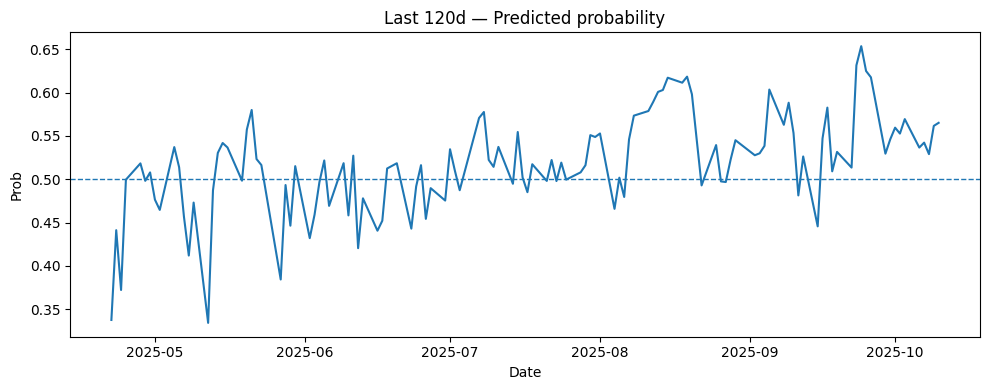

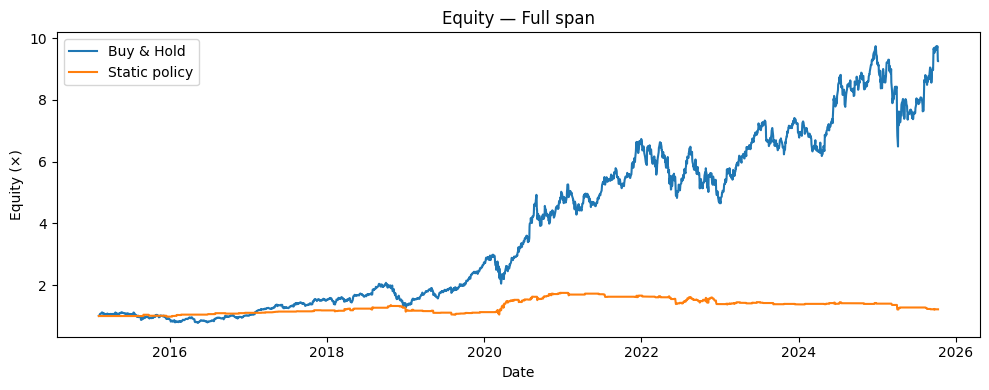

Saved figures -> reports/figures/status_probs_nb11.png and reports/figures/status_nb11.png


In [6]:
last = signals.tail(120).copy()

plt.figure(figsize=(10,4))
plt.plot(last["date"], last["prob"], label="prob (LR)")
plt.axhline(0.5, linestyle="--", linewidth=1)
plt.title("Last 120d — Predicted probability")
plt.xlabel("Date"); plt.ylabel("Prob")
plt.tight_layout()
plt.savefig(FIG_DIR/"status_probs_nb11.png", dpi=140)
plt.show()

plt.figure(figsize=(10,4))
eq_full = (1 + signals["ret_next"].fillna(0.0)).cumprod()
plt.plot(signals["date"], eq_full, label="Buy & Hold")
plt.plot(signals["date"], signals["equity"], label="Static policy")
plt.title("Equity — Full span")
plt.xlabel("Date"); plt.ylabel("Equity (×)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR/"status_nb11.png", dpi=140)
plt.show()

print("Saved figures ->", (FIG_DIR/"status_probs_nb11.png").as_posix(), "and", (FIG_DIR/"status_nb11.png").as_posix())


In [7]:
# NB11b — Auto-actions suggestion into monitor_snapshot.json
snap_path = ART_DIR/"monitor_snapshot.json"
assert snap_path.exists(), "Run Cell 5 first"

snap = json.loads(snap_path.read_text(encoding="utf-8"))

k   = snap.get("kpis", {}) or {}
auc = snap.get("classification", {}).get("AUC", None)
status = snap.get("status", "OK")
issues = snap.get("issues", []) or []

# Try to use dynamic signals if available for τ & coverage
dyn_path = DATA_DIR/"signals_dynamic.csv"
tau_dyn = None
cov60   = None
if dyn_path.exists():
    dyn = pd.read_csv(dyn_path, parse_dates=["date"])
    if "signal_dyn" in dyn.columns:
        cov60 = float(dyn["signal_dyn"].tail(ROLL_DAYS).mean())
    if "prob" in dyn.columns and len(dyn) >= 10:
        tau_dyn = float(np.quantile(dyn["prob"].tail(120).to_numpy(), 1.0 - 0.20))  # ~20% coverage

def bad(x, th, cmp="<"):
    try:
        x = float(x)
        if cmp == "<": return x < th
        if cmp == ">": return x > th
    except Exception:
        return False
    return False

should_pause = (status in {"ALERT","WARN"}) or bad(k.get("Sharpe"), SHARPE_ALERT, "<") or bad(auc, AUC_ALERT, "<")

suggestion = {
    "timestamp_utc": datetime.now(timezone.utc).isoformat(),
    "action": "pause" if should_pause else "trade",
    "reason": ("monitor_status" if status in {"ALERT","WARN"}
               else ("low_sharpe" if bad(k.get("Sharpe"), SHARPE_ALERT, "<")
               else ("low_auc" if bad(auc, AUC_ALERT, "<") else "ok"))),
    "new_tau": (None if should_pause else tau_dyn),
    "coverage60_dyn": cov60,
}

snap["action_suggestion"] = suggestion
snap_path.write_text(json.dumps(snap, indent=2), encoding="utf-8")
print("Wrote action_suggestion ->", snap_path.as_posix())
print("Suggestion:", suggestion)


Wrote action_suggestion -> artifacts/monitor_snapshot.json
Suggestion: {'timestamp_utc': '2025-10-23T00:31:05.316955+00:00', 'action': 'pause', 'reason': 'monitor_status', 'new_tau': None, 'coverage60_dyn': 0.0}
